In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path

from matplotlib import ticker, transforms
from mpl_axes_aligner import align
import matplotlib.pyplot as plt

In [2]:
api_key = 'N6sTD5Jriyd5fxO8Y19Dzw'
cases = 'corrected_covid_positive'

In [3]:
def query(sql, **kw):
    response = requests.get('https://joinzoe.carto.com/api/v2/sql/', params={
        'q':sql,
        'api_key':api_key
    })
    data = response.json()
    if 'error' in data:
        return data['error']
    return pd.DataFrame.from_records(data['rows'], **kw)

In [4]:
def pickle(df, name, for_date):
    path = f'~/Downloads/zoe_{name}_{for_date:%Y-%m-%d}_{datetime.now():%Y-%m-%d-%H-%M}.pickle'
    df.to_pickle(path)
    return path

In [5]:
tables = query("SELECT * FROM pg_catalog.pg_tables where tableowner!='postgres' order by tablename")
tables

['system tables are forbidden']

In [6]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index)

In [7]:
curr_date = uk_active_cases.index.max()
curr_est = uk_active_cases['corrected_covid_positive'].iloc[-1]
pickle(uk_active_cases, 'uk_active_cases', curr_date)

'~/Downloads/zoe_uk_active_cases_2020-08-05_2020-08-06-20-08.pickle'

In [17]:
prev_date = curr_date.date()
while True:
    prev_date -= timedelta(days=1)
    prev_uk_active_cases_glob = f'zoe_uk_active_cases_{prev_date}*'
    prev_uk_active_cases_paths = sorted(Path('~/Downloads/').expanduser().glob(prev_uk_active_cases_glob), reverse=True)
    if prev_uk_active_cases_paths:
        prev_uk_active_cases_path = prev_uk_active_cases_paths[0]
        break

prev_uk_active_cases = pd.read_pickle(prev_uk_active_cases_path)
prev_uk_active_cases_path

PosixPath('/Users/chris/Downloads/zoe_uk_active_cases_2020-08-03_2020-08-04-17-33.pickle')

In [25]:
prev_data_end = prev_date+timedelta(days=1)
diff = uk_active_cases[cases].sub(prev_uk_active_cases[cases], fill_value=0)
diff[prev_data_end:] = uk_active_cases[cases].diff()[prev_data_end:]

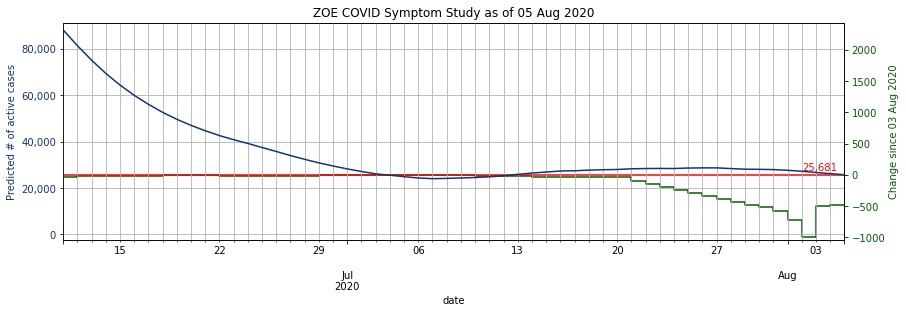

In [26]:
month_ago = datetime.now().date()-timedelta(days=30)
start = min(month_ago, diff.index.min()-timedelta(days=7))

data_colour = '#113377'
diff_colour = '#015c00'
curr_colour = 'red'
fig, ax = plt.subplots(figsize=(14, 4))
fig.set_facecolor('white')

data_to_plot = uk_active_cases[cases][start:]
data_to_plot.plot(ax=ax, grid=True, color=data_colour)
ax.set_title(f'ZOE COVID Symptom Study as of {curr_date:%d %b %Y}')
ax.xaxis.grid(True, which='minor')
ax.tick_params(axis='y', labelcolor=data_colour)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Predicted # of active cases', color=data_colour)

ax.axhline(y=curr_est, color=curr_colour, zorder=-100)
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(1, curr_est+1000, "{:,.0f}".format(curr_est), color=curr_colour, transform=trans, 
        ha="right", va="bottom", zorder=1000)
ax.patch.set_visible(False)

diff_ax = ax.twinx()
diff_ax.set_zorder(-1)
diff_ax.tick_params(axis='y', labelcolor=diff_colour)
diff_ax.set_ylabel(f'Change since {prev_date:%d %b %Y}', color=diff_colour)
diff_to_plot = diff.loc[start:].reindex(data_to_plot.index)
_ = diff_to_plot.plot(ax=diff_ax, drawstyle='steps', color=diff_colour, zorder=-1)
    
align.yaxes(ax, curr_est, diff_ax, 0, 0.3)

In [525]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)
prevalence_map

,cartodb_id,the_geom,the_geom_webmercator,objectid,lad16cd,lad16nm,lad16nmw,bng_e,bng_n,long,...,corrected_covid_positive,cases_pm,percentage,discrete_percentage,discrete_cases_pm,percentage_string,cases_pm_string,data_status,country,region
0,10949,0103000020E610000001000000C4010000AD9CD15F9CE2...,0103000020110F000001000000C40100000AEC1A1775E3...,1,E06000001,Hartlepool,None,447157,531476,-1.27023,...,46.664953,1147.07,0.114707,0.10,1000,0.1 %,1147,05:00:02 29-07-2020,England,North East
1,10961,0106000020E61000000300000001030000000100000004...,0106000020110F00000300000001030000000100000004...,13,E06000013,North Lincolnshire,None,497798,410996,-0.52410,...,0.000000,0,0.000000,0.00,0,0.0 %,0,05:00:02 29-07-2020,England,Yorkshire and The Humber
2,10950,0106000020E61000000200000001030000000100000013...,0106000020110F00000200000001030000000100000013...,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,...,0.000000,0,0.000000,0.00,0,0.0 %,0,05:00:02 29-07-2020,England,North East
3,10951,0106000020E61000000200000001030000000100000006...,0106000020110F00000200000001030000000100000006...,3,E06000003,Redcar and Cleveland,None,464359,519597,-1.00611,...,86.503517,1428.77,0.142877,0.10,1000,0.1 %,1429,05:00:02 29-07-2020,England,North East
4,10952,0106000020E61000000200000001030000000100000025...,0106000020110F00000200000001030000000100000025...,4,E06000004,Stockton-on-Tees,None,444937,518183,-1.30669,...,176.864913,1816.98,0.181698,0.10,1000,0.2 %,1817,05:00:02 29-07-2020,England,North East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,11318,0106000020E610000002000000010300000001000000B0...,0106000020110F000002000000010300000001000000B0...,389,W06000022,Newport,Casnewydd,337897,187433,-2.89769,...,44.733255,505.078,0.050508,0.05,500,0.1 %,505,05:00:02 29-07-2020,Wales,Wales
387,11319,0103000020E6100000010000006D1000003E242470162E...,0103000020110F0000010000006D10000087DF530DAA62...,390,W06000023,Powys,Powys,302328,273254,-3.43533,...,72.403819,740.371,0.074037,0.05,500,0.1 %,740,05:00:02 29-07-2020,Wales,Wales
388,11320,0103000020E61000000100000060010000CAAE459CF9AC...,0103000020110F0000010000006001000038E916C4D9A7...,391,W06000024,Merthyr Tydfil,Merthyr Tudful,305916,206424,-3.36425,...,15.431120,430.376,0.043038,0.01,100,0.0 %,430,05:00:02 29-07-2020,Wales,Wales
389,11321,0103000020E610000001000000C0000000CA21EFF2CDF8...,0103000020110F000001000000C0000000F7A9DBECED86...,325,E09000032,Wandsworth,None,525152,174137,-0.20021,...,143.026688,557.681,0.055768,0.05,500,0.1 %,558,05:00:02 29-07-2020,England,London


In [526]:
for_date, = prevalence_map['data_status'].unique()
pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y'))

'~/Downloads/zoe_prevalence_map_2020-07-29_2020-07-29-21-19.pickle'

In [527]:
prevalence_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cartodb_id                      391 non-null    int64  
 1   the_geom                        391 non-null    object 
 2   the_geom_webmercator            391 non-null    object 
 3   objectid                        391 non-null    int64  
 4   lad16cd                         391 non-null    object 
 5   lad16nm                         391 non-null    object 
 6   lad16nmw                        22 non-null     object 
 7   bng_e                           391 non-null    int64  
 8   bng_n                           391 non-null    int64  
 9   long                            391 non-null    float64
 10  lat                             391 non-null    float64
 11  st_areasha                      391 non-null    float64
 12  st_lengths                      391 

In [528]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
180,Preston,E07000123,0.844983
181,Rossendale,E07000125,0.420848
131,Scarborough,E07000168,0.392210
10,Blackburn with Darwen,E06000008,0.343988
300,Salford,E08000006,0.316685
323,Calderdale,E08000033,0.259451
324,Kirklees,E08000034,0.255999
304,Wigan,E08000010,0.254287
12,Blackpool,E06000009,0.240308
326,Wakefield,E08000036,0.235114


In [529]:
import geopandas
import shapely
from geopandas import GeoDataFrame
import glob
from pathlib import Path
from dateutil.parser import parse as parse_date

In [530]:
def convert_df(df, geom_col):
    geoms = df[geom_col]
    df[geom_col] = geoms = geoms.apply(lambda x: shapely.wkb.loads(str(x), hex=True))
    crs = "epsg:{}".format(shapely.geos.lgeos.GEOSGetSRID(geoms.iat[0]._geom))
    return GeoDataFrame(df, crs=crs, geometry=geom_col)

/Users/chris/miniconda3/envs/coronavirus/lib/python3.8/site-packages/geopandas/plotting.py:332: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


Text(0.5, 1.0, 'ZOE COVID Symptom Study data for 29 Jul 2020')

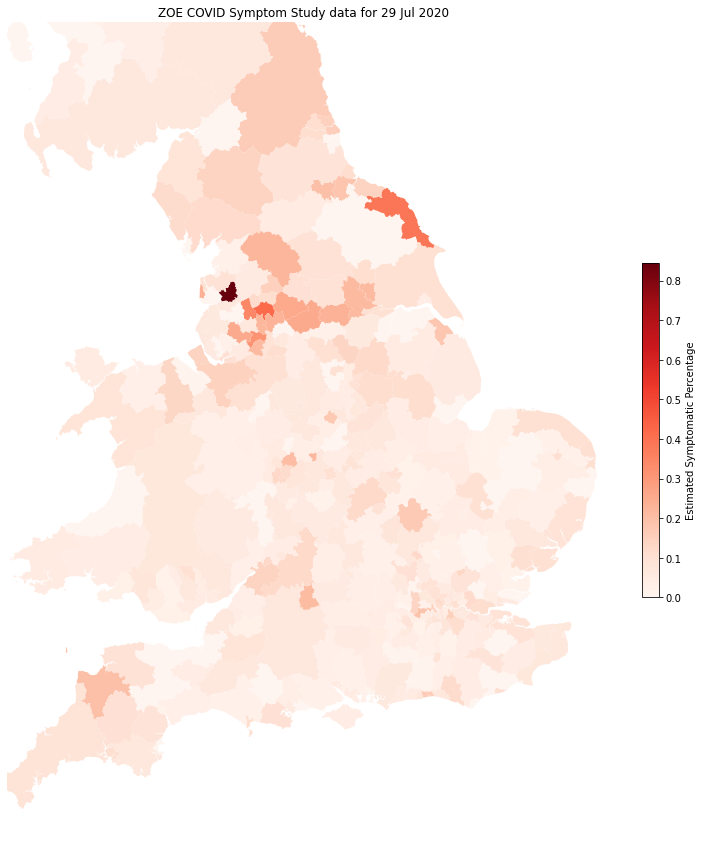

In [531]:
path = sorted(Path('~/Downloads/').expanduser().glob(f'zoe_prevalence_map_*.pickle'), reverse=True)[0]
date = parse_date(str(path).rsplit('_')[-2]).date()
df = pd.read_pickle(path)
gdf = convert_df(df, 'the_geom_webmercator')
ax = gdf.plot(
    column='percentage', 
    k=10, figsize=(15, 15), 
    cmap='Reds', 
    legend=True, 
    legend_kwds={'fraction': 0.02, 'anchor': (0, 0), 'label': 'Estimated Symptomatic Percentage'},
    missing_kwds={'color': 'lightgrey'},
)
ax.set_axis_off()

# ignore shetlands, no data anyway
ax.set_ylim(6400000, 8200000)

# south of england:
#ax.set_ylim(6500000, 6850000)
#ax.set_xlim(-400000,  100000)

# england
ax.set_ylim(6400000, 7500000)
ax.set_xlim(-600000,  200000)


ax.set_title(f'ZOE COVID Symptom Study data for {date:%d %b %Y}')